توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [ ]:
## download data
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([transforms.ToTensor()])


dataset_train = ImageFolder('ADEChallengeData2016/images', transform=transform)
dataset_val = ImageFolder('ADEChallengeData2016/images', transform=transform)
dataset_test = ImageFolder('release_test', transform=transform)



In [ ]:
import os
import cv2
import numpy as np
import torch
import glob
from PIL import Image
import matplotlib.pyplot as plt
from cv2 import imread as IM
from os import path
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split
from random import randint

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [ ]:
import torch
import torch.nn.functional as F
# function 1, This function adds a random displacement to the input image such that there is not any black box in the final image, and the output size will be the same as the input size.
def displacement(img,temp):
  img = img.permute(2,1,0)                                                      # permute from C*H*W to H*W*C
  img = img.numpy()                                                             # from torch to numpy
  height, width, c = img.shape
  max_displacement = 40                                                         # the range of displacement
  dx = random.randint(-max_displacement, max_displacement)                      # displacement value in x axis
  dy = random.randint(-max_displacement, max_displacement)                      # displacement value in y axis
  M = np.float32([[1, 0, dx], [0, 1, dy]])                                      # displacement matrix
  displaced_image = cv2.warpAffine(img, M, (height, width))                     # insert displacement into the matrix(np version)
  nonzero_coords = cv2.findNonZero(cv2.cvtColor(displaced_image, cv2.COLOR_BGR2GRAY))
  (x, y, w, h) = cv2.boundingRect(nonzero_coords)
  cropped_image = displaced_image[y:y+h, x:x+w]
  resized_image = cv2.resize(cropped_image, (height, width))                    # resize the image to its original shape
  img = torch.from_numpy(resized_image)                                         # from numpy to torch
  img = img.squeeze(0).permute(2,1,0)                                           # permute from H*W*C to C*H*W
  img = img/img.max()
  return img

# function 2, This function adds a random rotation to the input image such that there is not any black triangle in the corners of the rotated image, and the output size will be the same as the input size.
def rotation(img):
  img = img.permute(2,1,0)                                                      # permute from C*H*W to H*W*C
  img = img.numpy()                                                             # from torch to numpy
  height, width, c = img.shape
  angle = np.random.uniform(-75, 75)                                            # the range of rotation angle (random)
  rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)      # create the rotation matrix around the center of the image
  rotated_image = cv2.warpAffine(img, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE) # rotate the matrix
  nonzero_coords = cv2.findNonZero(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)) # find the central image(image without black areas)
  (x, y, w, h) = cv2.boundingRect(nonzero_coords)                               # find the location of bounding rectangle(image without black areas)
  cropped_image = rotated_image[y:y+h, x:x+w]                                   # remove black areas
  resized_image = cv2.resize(cropped_image, (height, width))                    # resize the image to its original shape
  img = torch.from_numpy(cropped_image)                                         # from numpy to torch
  img = img.squeeze(0).permute(2,1,0)                                           # permute from H*W*C to C*H*W
  img = img/img.max()
  return img


# function 3, this function randomly scales the input image along the x and y axes.
def scaling(img):
  img = img.permute(2,1,0)                                                      # permute from C*H*W to H*W*C
  img = img.numpy()                                                             # from torch to numpy
  height, width = img.shape[:2]
  scale_x = random.uniform(0.5, 2.0)                                            # scaling factor along x axis (random)
  scale_y = random.uniform(0.5, 2.0)                                            # scaling factor along y axis (random)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img_scaled = cv2.resize(img, (int(height * scale_x), int(width * scale_y)))   # scale the image
  img = torch.from_numpy(img_scaled)                                            # from numpy to torch
  img = img.squeeze(0).permute(2,1,0)                                           # permute from H*W*C to C*H*W
  img = img/img.max()
  return img



# function 4
def Brightness(img):  ## for augmentation, this function changes the birghtness of the input iamge by random
  img = img.permute(2,1,0)                                                      # permute from C*H*W to H*W*C
  img = img.numpy()                                                             # from torch to numpy
  brightness = img.max()*random.random()                                        # generate the random brighness factor
  brightness_array = np.full_like(img, brightness)                              # create the brightness matrix
  brightened_image = cv2.add(img, brightness_array)                             # add brightness to the image
  img = torch.from_numpy(brightened_image)                                      # from numpy to torch
  img = img.squeeze(0).permute(2,1,0)                                           # permute from H*W*C to C*H*W
  img = img - img.min()
  img = img/img.max()
  return img



# function 5
def bluring(img):# for augmentation, this function blurs the input image under 15-by-15 bluring matrices
  ## To Do
  img = img.permute(2,1,0)                                                      # permute from C*H*W to H*W*C
  img = img.numpy()                                                             # from torch to numpy
  img_blurred = cv2.blur(img, (15, 15))                                         # blur the image under 15-by-15 bluring matrix
  img = torch.from_numpy(img_blurred)                                           # from numpy to torch
  img = img.squeeze(0).permute(2,1,0)                                           # permute from H*W*C to C*H*W
  img = img/img.max()
  return img

# function 6
def gaussian_noise(img):#for augmentation, this function generates noisy images by generating additive white Gaussian noise
  img = img.permute(2,1,0)
  noise = np.random.normal(0, 0.1*img.max(), img.shape).astype('float32')       # generate Gaussian noise
  img = img.numpy()                                                             # from torch to numpy
  img_noisy = cv2.add(img, noise)                                               # add noise to the image
  img = torch.from_numpy(img_noisy)                                             # from numpy to torch
  img = img.squeeze(0).permute(2,1,0)                                           # permute from H*W*C to C*H*W
  img = img - img.min()
  img = img/img.max()

  return img


def fix_size224(img):
  img = F.interpolate(img.unsqueeze(0), size=(224,224), mode='bilinear', align_corners=False)
  img = img.squeeze(0)
  img = img/img.max()
  return img

In [ ]:
class CustomDataset(Dataset):

    def __init__(self,data):
      self.data = data
      self.data_size = len(data)
      self.targets = []
    def __getitem__(self,index):
      if index % 8 == 0:
        img,temp = self.data[index]
        #d = displacement(d, 20)
        #d = rotation(d)
        #d = scaling(d)
        d = fix_size224(img)
        lbl = torch.tensor([0.0,0.0,0.0])
        return d, d, lbl

      if index % 8 == 1:
        img,temp = self.data[index]
        d = displacement(img, 20)
        #d = rotation(d)
        #d = scaling(d)
        d2 = fix_size224(d)
        d1 = fix_size224(img)
        lbl = torch.tensor([0.0,0.0,1.0])
        return d1,d2, lbl

      if index % 8 == 2:
        img,temp = self.data[index]
        #d = displacement(self.data[index], 20)
        d = rotation(img)
        #d = scaling(d)
        d2 = fix_size224(d)
        d1 = fix_size224(img)
        lbl = torch.tensor([0.0,1.0,0.0])
        return d1,d2, lbl

      if index % 8 == 3:
        img,temp = self.data[index]
        d = displacement(img, 20)
        d = rotation(d)
        #d = scaling(d)
        d2 = fix_size224(d)
        d1 = fix_size224(img)
        lbl = torch.tensor([0.0,1.0,1.0])
        return d1,d2, lbl
      if index % 8 == 4:
        img,temp = self.data[index]
        #d = displacement(self.data[index], 20)
        #d = rotation(d)
        d = scaling(img)
        d2 = fix_size224(d)
        d1 = fix_size224(img)
        lbl = torch.tensor([1.0,0.0,0.0])
        return d1,d2, lbl

      if index % 8 == 5:
        img,temp = self.data[index]
        d = displacement(img, 20)
        #d = rotation(d)
        d = scaling(d)
        lbl = torch.tensor([1.0,0.0,1.0])
        d2 = fix_size224(d)
        d1 = fix_size224(img)
        return d1,d2, lbl

      if index % 8 == 6:
        img,temp = self.data[index]
        #d = displacement(self.data[index], 20)
        d = rotation(img)
        d = scaling(d)
        lbl = torch.tensor([1.0,1.0,0.0])
        d2 = fix_size224(d)
        d1 = fix_size224(img)
        return d1,d2, lbl

      if index % 8 == 7:                    # augmentation
        num = random.randint(1,10)
        if num % 3 == 0:
          img,temp = self.data[index]
          img = Brightness(img)
          d = fix_size224(img)
          lbl = torch.tensor([0.0,0.0,0.0])
        if num % 3 == 1:
          img,temp = self.data[index]
          img = bluring(img)
          d = fix_size224(img)
          lbl = torch.tensor([0.0,0.0,0.0])
        if num % 3 == 2:
          img,temp = self.data[index]
          img = gaussian_noise(img)
          d = fix_size224(img)
          lbl = torch.tensor([0.0,0.0,0.0])

        return d, d, lbl

    def __len__(self):
      ## To Do
      return len(self.data)


In [ ]:
dataset_trn = dataset_train
dataset_vld = dataset_val

dataset_trn.samples = dataset_train.samples[:500]
dataset_trn.targets = dataset_train.targets[:500]

dataset_vld.samples = dataset_val.samples[500:600]
dataset_vld.targets = dataset_val.targets[500:600]

dataset_test.samples = dataset_test.samples[:500]
dataset_test.targets = dataset_test.targets[:500]

dataset_train = CustomDataset(dataset_trn)
dataset_test = CustomDataset(dataset_test)
dataset_val = CustomDataset(dataset_vld)


train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True)
test_loader= DataLoader(dataset_test, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset_vld,batch_size=8, shuffle=True)


Original(train):


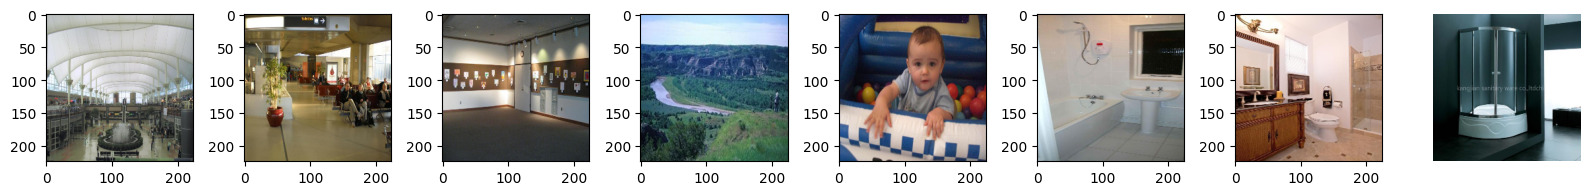

Custom (train):


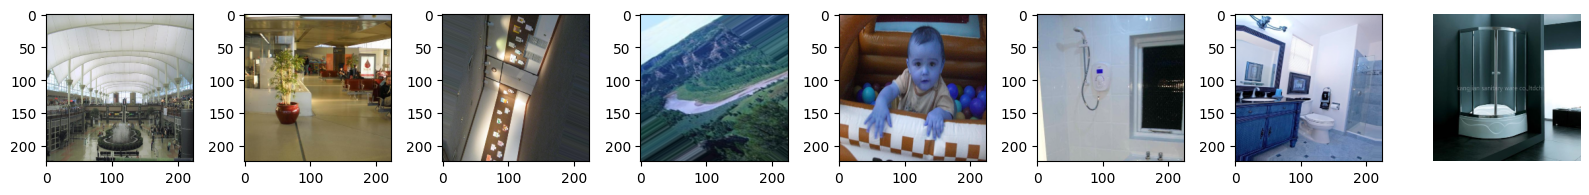

Original (test):


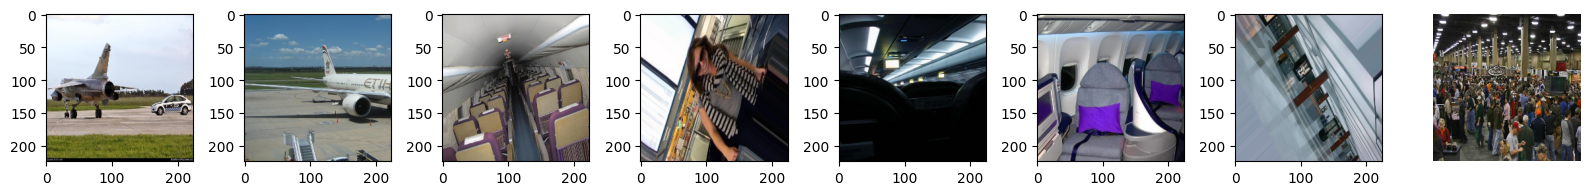

Custom (test):


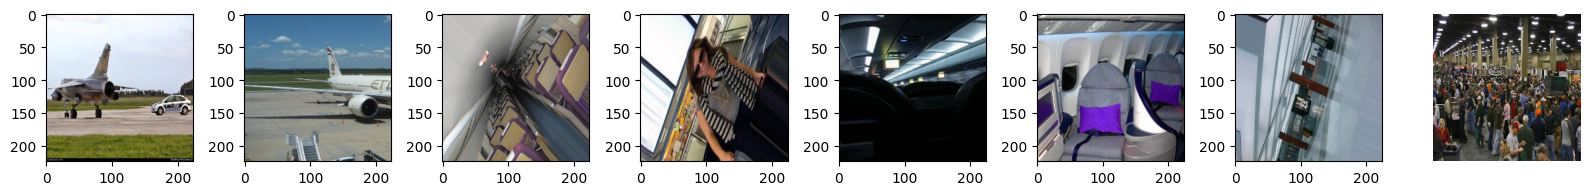

augmented(test):


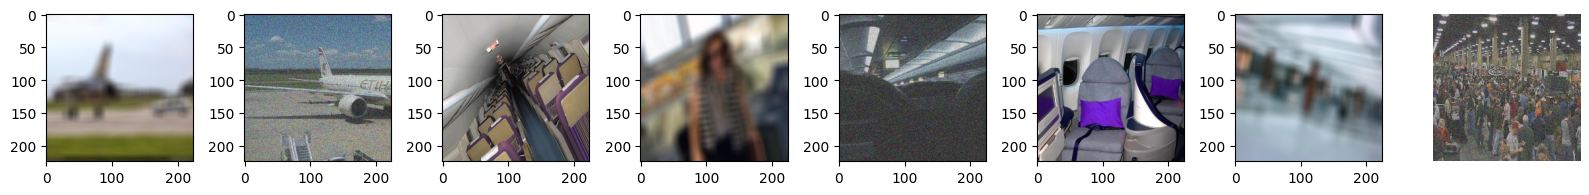

In [ ]:
## To Do  : show 8 images from train_loader & 8 images from test_loader
print("Original(train):")
fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
  img1,img2,_ = dataset_train.__getitem__(i)
  img1 = img1.permute(1,2,0)
  axes[i].imshow(img1)

plt.axis('off')
plt.tight_layout()
plt.show()

print("Custom (train):")
fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
  img1,img2,_ = dataset_train.__getitem__(i)
  img2 = img2.permute(1,2,0)
  axes[i].imshow(img2)

plt.axis('off')
plt.tight_layout()
plt.show()

print("Original (test):")
fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
  img1,img2,_ = dataset_test.__getitem__(i)
  img2 = img2.permute(1,2,0)
  axes[i].imshow(img2)

plt.axis('off')
plt.tight_layout()
plt.show()

print("Custom (test):")
fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
  img1,img2,_ = dataset_test.__getitem__(i)
  img2 = img2.permute(1,2,0)
  axes[i].imshow(img2)

plt.axis('off')
plt.tight_layout()
plt.show()

print("augmented(test):")
fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
  img1,img2,_ = dataset_test.__getitem__(i)
  if i % 3 == 0:
    img2 = bluring(img2)
  if i % 3 == 1:
    img2 = gaussian_noise(img2)
  if i % 3 == 2:
    img2 = Brightness(img2)
  img2 = img2.permute(1,2,0)
  axes[i].imshow(img2)

plt.axis('off')
plt.tight_layout()
plt.show()



##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

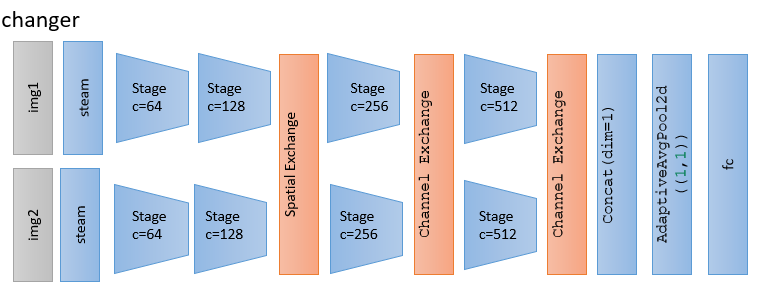

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


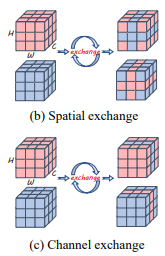

In [ ]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

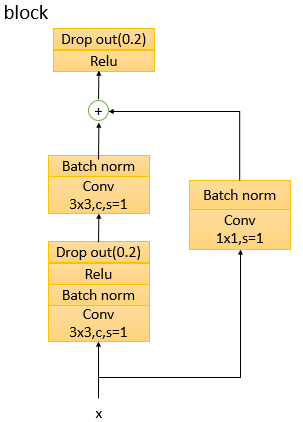

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





**Answer:**
According to the size of the kernels (3*3) and our desire to keep the size of the maps fixed, I have set the padding to 1. note that:

output = (input +2*padding - kernel)/stride  + 1


As we know, Conv(1-by-1) is used to *control* the number of output channels. In our application, we want to add the outputs, so the number of the channels have to be equal. Accordingly, I have set the channel out size to channel output size of the second branch.

In [ ]:
##To Do
class block(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(block,self).__init__()
    self.conv0 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)       # 2d convolutional object
    self.conv1 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)      # 2d convolutional object
    self.batch_norm1 = nn.BatchNorm2d(out_channels)                                             # batch normalizer
    self.relu1 = nn.ReLU()                                                                      # activation
    self.dropout1 = nn.Dropout2d(p=0.2)                                                         # Dropout reg
    self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)                  # 1-by-1 conv layer



  def forward(self, x):
    # branch 1:
    # first sub-block
    out1 = self.conv0(x)            #conv 3*3
    out1 = self.batch_norm1(out1)   # batch_norm
    out1 = self.relu1(out1)         # activation
    out1 = self.dropout1(out1)      # dropout
    # second sub-block
    out1 = self.conv1(out1)         # conv 3*3
    out1 = self.batch_norm1(out1)   # batch-norm
    # branch 2:
    out2 = self.conv2(x)            # conv 3*3
    out1 = self.batch_norm1(out1)   # batch_nrom
    # output:
    out = torch.add(out1, out2)

    return out

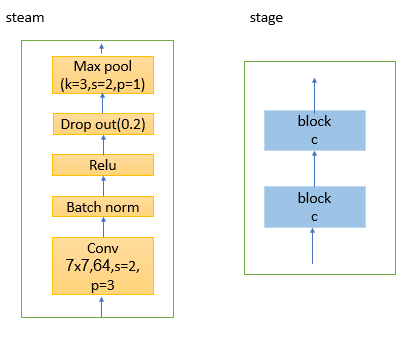

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [ ]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange,c1,c2,c3,c4):
    super(changer,self).__init__()
    self.SpatialExchange = SpatialExchange()          # spatialExchange module
    self.ChannelExchange = ChannelExchange()          # channelExchange module
    self.steam=nn.Sequential(                         # initialize steam moduel
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout2d(0.2),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
    # according to the image above, we initialize the modules in order:
    self.stage1= self._make_stage(block(64,c1),block(c1,c1))
    self.stage2= self._make_stage(block(c1,c2),block(c2,c2))
    self.stage3= self._make_stage(block(c2,c3),block(c3,c3))
    self.stage4= self._make_stage(block(c3,c4),block(c4,c4))
    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc_layer = nn.Linear(2*c4, 3)      # classifier




  def _make_stage(self,b1,b2):

    layers=[]
    layers.append(b1)
    layers.append(b2)

    return nn.Sequential(*layers)



# based on the image, we write the forward pass of the network in the following method:
  def forward(self,x1,x2):
    out1 = self.steam(x1)
    out2 = self.steam(x2)

    out1 = self.stage1(out1)
    out2 = self.stage1(out2)

    out1 = self.stage2(out1)
    out2 = self.stage2(out2)

    out1, out2 = self.SpatialExchange(out1,out2)

    out1 = self.stage3(out1)
    out2 = self.stage3(out2)

    out1, out2 = self.ChannelExchange(out1,out2)

    out1 = self.stage4(out1)
    out2 = self.stage4(out2)

    out1, out2 = self.ChannelExchange(out1,out2)
    out = torch.cat((out1, out2), dim=1)
    out = self.avg_pool(out)
    out = out.squeeze()     # squeeze the output in one dimension
    out = self.fc_layer(out)
    out = torch.sigmoid(out)    # sigmoid activation (probability)

    return out

In [ ]:
## To Do
device = "cuda" if torch.cuda.is_available() else "cpu"



model=changer(block,SpatialExchange,ChannelExchange,64,128,256,512).to(device) # initialize the model and transfer to cuda

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

##Train & validation


In [ ]:

Loss_train = []
Loss_val   = []
Acc_train  = []
Acc_val    = []
model = model.to(device)

for epoch in range(5):  # The number of epochs are adjusted to 5
    running_loss = 0.0  # epoch loss
    acc = 0.0           # epoch accuracy
    for i, (img1,img2,lbl) in enumerate(train_loader):
        inputs1, inputs2, labels = img1,img2,lbl
        inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs1,inputs2)
        threshold = 0.5   #set threshold to calculate accuracy
        predicted_labels = (outputs.data >= threshold).int()
        correct = (predicted_labels == labels).sum().item()

        total = labels.size(0)
        acc  += (100 * correct / total)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    Loss_train.append(running_loss/len(val_loader))
    Acc_train.append(acc)
    running_loss = 0.0  # epoch loss
    acc = 0.0           # epoch accuracy
    for i, (img1,img2,lbl) in enumerate(val_loader):
      inputs1, inputs2, labels = img1,img2,lbl
      inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
      outputs = model(inputs1,inputs2)
      threshold = 0.5   #set threshold to calculate accuracy
      predicted_labels = (outputs.data >= threshold).int()
      correct = (predicted_labels == labels).sum().item()
      total = labels.size(0)
      acc  += (100 * correct / total)
      loss = criterion(outputs, labels)
    Loss_val.append(running_loss/len(val_loader))
    Acc_val.append(acc)
    print(f'Epoch: {epoch + 1}, Average Loss: {running_loss/len(val_loader):.3f}, Accuracy on the train set: {( acc):.2f}%')







#Test


In [ ]:
#checkpoint = torch.load('#To Do')
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

# Test the network
Loss_test = 0.0
Acc_test = 0.0
Acc_test_class1 = 0.0
Acc_test_class2 = 0.0
num1 = 0.0
num2 = 0.0
with torch.no_grad():
    for i,(img1,img2,lbl) in enumerate(test_loader):
        inputs1, inputs2, labels = img1,img2,lbl
        inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
        outputs = model(inputs1,inputs2)
        threshold = 0.5                                                          #set threshold to calculate accuracy
        predicted_labels = (outputs.data >= threshold).int()
        correct = (predicted_labels == labels).sum().item()
        total = labels.size(0)
        Acc_test  += (100 * correct / total / 3)
        for j in range(len(labels)):
          if labels[j,:].sum().item() == 1:
            correct1 = (predicted_labels[j,:] == labels[j,:]).sum().item()
            num1 += 3
          if labels[j,:].sum().item() == 2:
            correct2 = (predicted_labels[j,:] == labels[j,:]).sum().item()
            num2 += 3
        Loss_test += criterion(outputs, labels)

    Acc_test_class1 += (100 * correct1 / num1)
    Acc_test_class2 += (100 * correct2 / num2)
    Acc_test = Acc_test/len(test_loader)
    Loss_test = Loss_test/len(test_loader)

#print(f'loss_TRAIN ={Sum_loss:.3f},acc_train={(num_correct_train)},\t loss_val= {loss_val:.3f}, acc_val={(num_correct_val)}')

print(f' loss_test= {Loss_test:.3f}, acc_test={Acc_test}')


 loss_test= 1.159, acc_test=59.854497354497354


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

In [ ]:
print(f' test accuracy with just one change {Acc_test_class1}')
print(f' test accuracy with two change {Acc_test_class2}')


 test accuracy with just one change 0.5319148936170213
 test accuracy with two change 0.35650623885918004


As expected, the accuracy of the predictions related to one change is greater that the one related to two changes. As suggested in Telegram group, we have not the three-change mode in our data.